# This example was taken from

https://medium.com/@LeonFedden/comparative-audio-analysis-with-wavenet-mfccs-umap-t-sne-and-pca-cb8237bfce2f

All the information 

### All the relevant imports we'll need!

#### You'll need to install magenta!

pip install magenta

pip install umap-learn

In [1]:
import os
import csv
import umap
import json
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen

np.random.seed(8)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


Here we get all the mfccs and wavenet state data and save it to be dimensionally reduced. You can download the model weights from: http://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar

In [2]:
def wavenet_encode(file_path):
    neural_sample_rate = 16000
    audio = utils.load_audio(file_path, 
                             sample_length=400000, 
                             sr=neural_sample_rate)
    encoding = fastgen.encode(audio, './wavenet-ckpt/model.ckpt-200000', len(audio))
    return encoding.reshape((-1, 16))


banned_words = ['example']
directory = './btq112cutext1/mp3/'
dataset = []
errors = 0
        
sample_rate = 44100
mfcc_size = 13

for file in os.listdir(directory):
    
    contains_banned = [word in file for word in banned_words]

    if file.endswith('.mp3') and not np.any(contains_banned):
        file_path = os.path.join(directory, file)
        
        try:
            wavenet_data = wavenet_encode(file_path)
        
            stddev_wavenet = np.std(wavenet_data, axis=0)

            mean_wavenet = np.mean(wavenet_data, axis=0)

            average_difference_wavenet = np.zeros((16,))
            for i in range(0, len(wavenet_data) - 2, 2):
                average_difference_wavenet += wavenet_data[i] - wavenet_data[i+1]
            average_difference_wavenet /= (len(wavenet_data) // 2)   
            average_difference_wavenet = np.array(average_difference_wavenet)

            concat_features_wavenet = np.hstack((stddev_wavenet, mean_wavenet))
            concat_features_wavenet = np.hstack((concat_features_wavenet, average_difference_wavenet))

            data, _ = librosa.load(file_path)

            trimmed_data, _ = librosa.effects.trim(y=data)

            mfccs = librosa.feature.mfcc(trimmed_data, 
                                         sample_rate, 
                                         n_mfcc=mfcc_size)

            stddev_mfccs = np.std(mfccs, axis=1)

            mean_mfccs = np.mean(mfccs, axis=1)

            average_difference = np.zeros((mfcc_size,))
            for i in range(0, len(mfccs.T) - 2, 2):
                average_difference += mfccs.T[i] - mfccs.T[i+1]
            average_difference /= (len(mfccs) // 2)   
            average_difference = np.array(average_difference)

            concat_features = np.hstack((stddev_mfccs, mean_mfccs))
            concat_features = np.hstack((concat_features, average_difference))
            
            
            dataset += [(file, concat_features_wavenet, concat_features)]
        
        except:
            print("error! " + file)
            errors += 1
        
print('errors:', errors)

INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Restoring

This is some specific code to prep the data for plotting and to be saved to json for the html visualisation

In [3]:
all_file_paths, wavenet_features, mfcc_features = zip(*dataset)
    
wavenet_features = np.nan_to_num(np.array(wavenet_features))
mfcc_features = np.array(mfcc_features)

mfcc_tuples = []
wavenet_tuples = []

all_json = dict()
all_json["filenames"] = all_file_paths

print(len(all_file_paths), 
      wavenet_features.shape, 
      mfcc_features.shape)

50 (50, 48) (50, 39)


### Making and plotting the t-SNE embeddings!

In [18]:
def get_scaled_tsne_embeddings(features, perplexity, iteration):
    embedding = TSNE(n_components=2,
                     perplexity=perplexity,
                     n_iter=iteration).fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)


def transform_numpy_to_json(array):
    data = []
    for position in array:
        data.append({
            'coordinates': position.tolist()
        })
    return data


tnse_embeddings_mfccs = []
tnse_embeddings_wavenet = []
perplexities = [2, 5, 30, 50, 100]
iterations = [250, 500, 1000, 2000, 5000]
for i, perplexity in enumerate(perplexities):
    for j, iteration in enumerate(iterations):
        tsne_mfccs = get_scaled_tsne_embeddings(mfcc_features,
                                                perplexity,
                                                iteration)
        tnse_wavenet = get_scaled_tsne_embeddings(wavenet_features,
                                                  perplexity,
                                                  iteration)
        tnse_embeddings_mfccs.append(tsne_mfccs)
        tnse_embeddings_wavenet.append(tnse_wavenet)
        
        mfcc_key = 'tsnemfcc{}{}'.format(i, j) 
        wavenet_key = 'tsnewavenet{}{}'.format(i, j) 
        
        all_json[mfcc_key] = transform_numpy_to_json(tsne_mfccs)
        all_json[wavenet_key] = transform_numpy_to_json(tnse_wavenet)

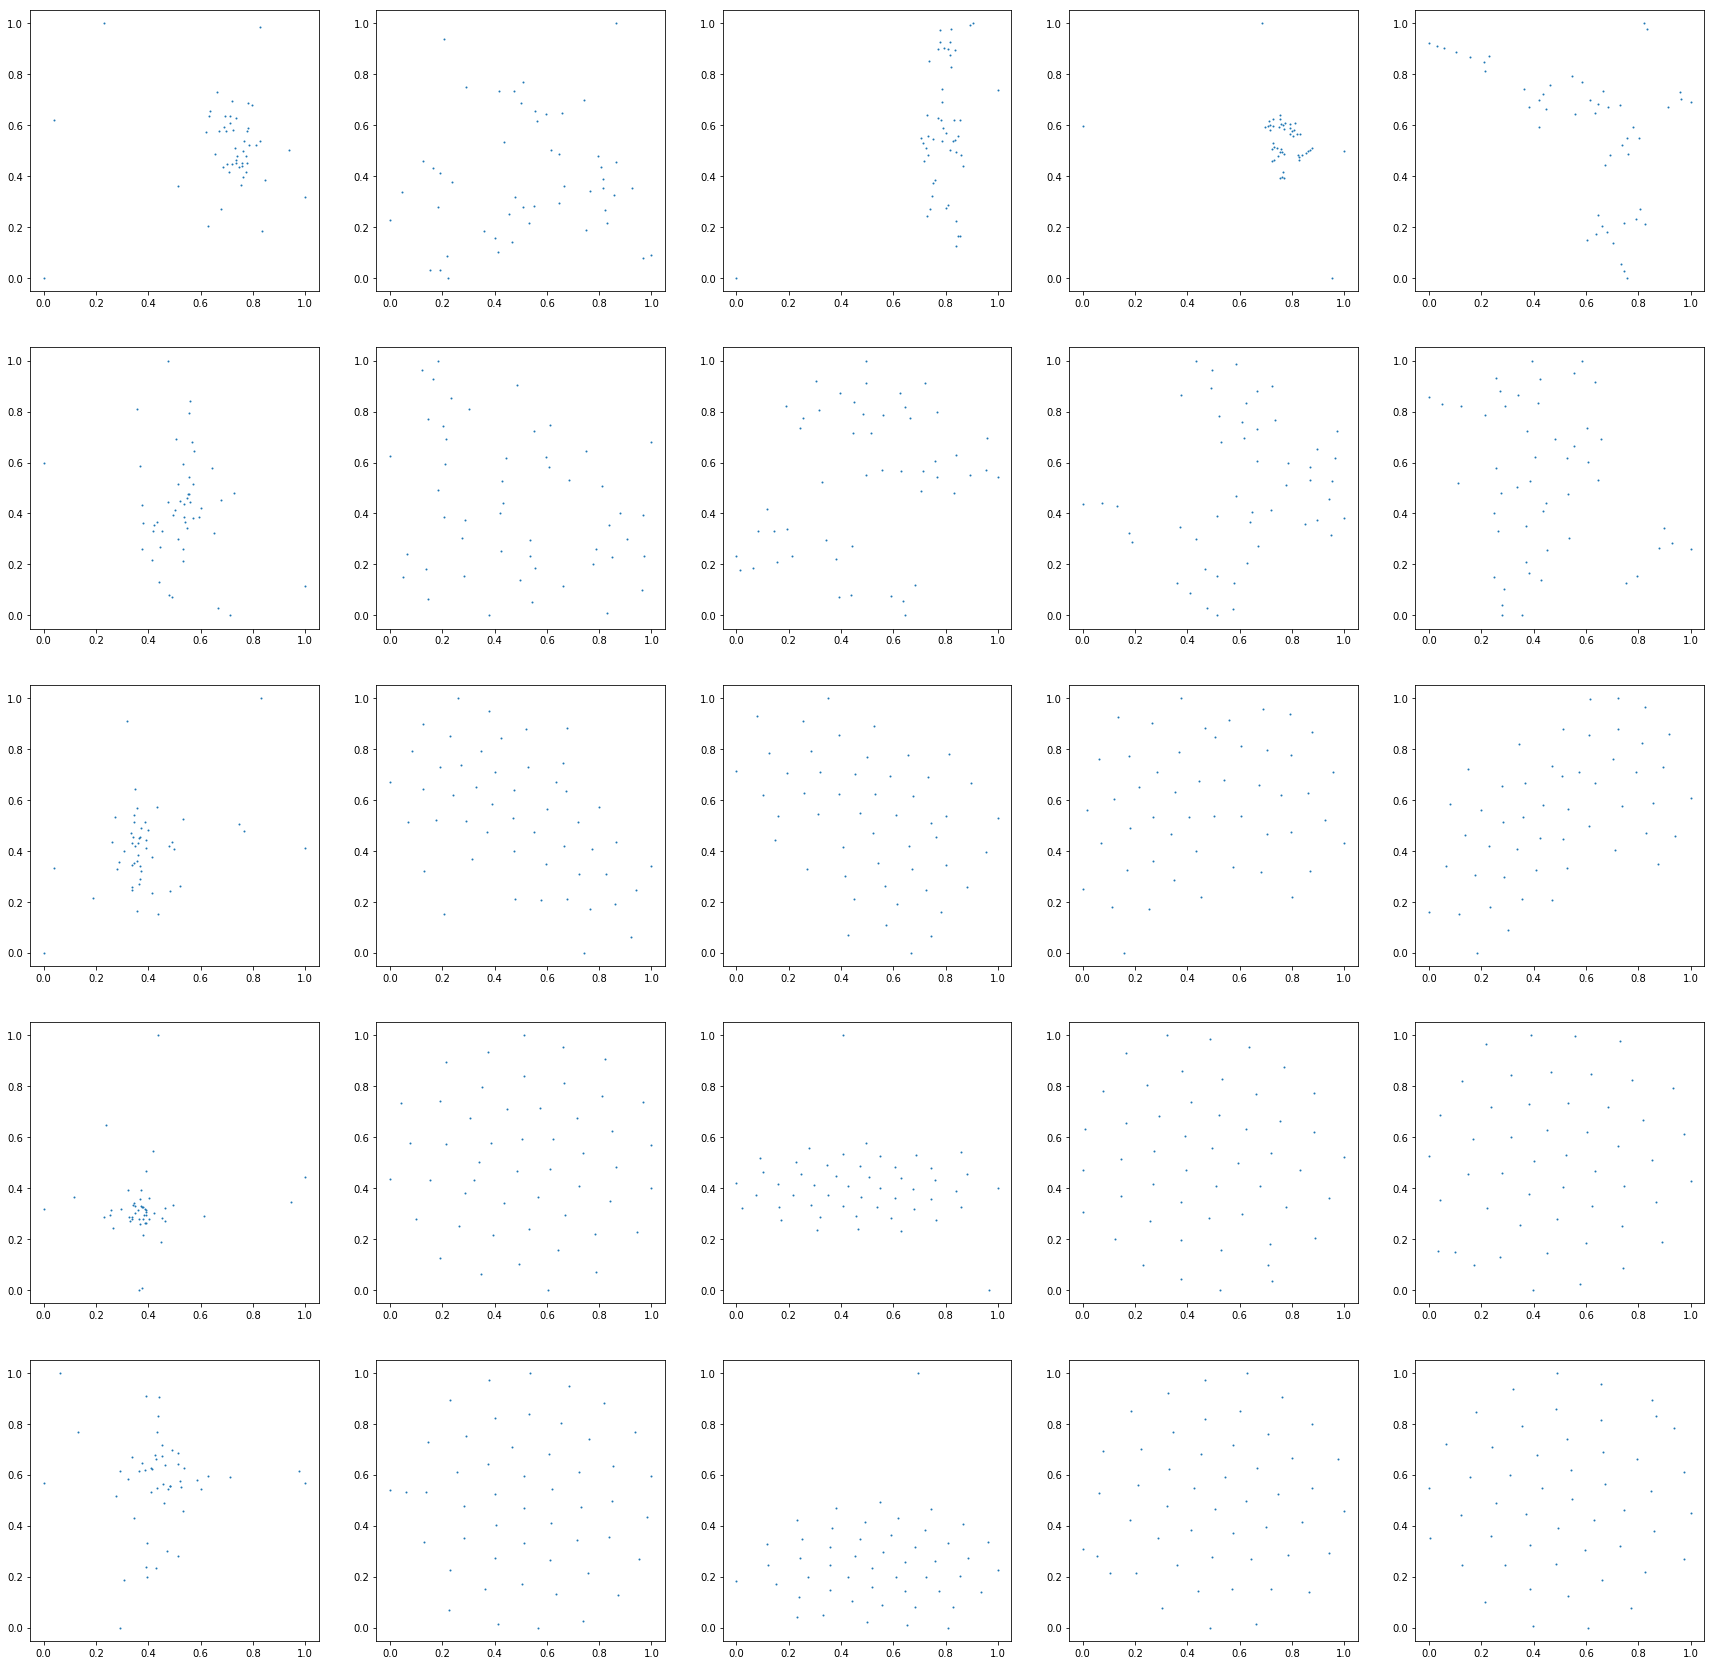

In [19]:
fig, ax = plt.subplots(nrows=len(perplexities), 
                       ncols=len(iterations),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(iterations) + j
        col.scatter(tnse_embeddings_mfccs[current_plot].T[0], 
                    tnse_embeddings_mfccs[current_plot].T[1], 
                    s=1)
plt.show()

### Here is the code to make and plot the UMAP embeddings!

In [12]:
def get_scaled_umap_embeddings(features, neighbour, distance):
    
    embedding = umap.UMAP(n_neighbors=neighbour,
                          min_dist=distance,
                          metric='correlation').fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)


umap_embeddings_mfccs = []
umap_embeddings_wavenet = []
neighbours = [5, 10, 20, 30, 40]
distances = [0.000, 0.001, 0.01, 0.1, 0.5]
for i, neighbour in enumerate(neighbours):
    for j, distance in enumerate(distances):
        umap_mfccs = get_scaled_umap_embeddings(mfcc_features,
                                                neighbour,
                                                distance)
        umap_wavenet = get_scaled_umap_embeddings(wavenet_features,
                                                  neighbour,
                                                  distance)
        umap_embeddings_mfccs.append(umap_mfccs)
        umap_embeddings_wavenet.append(umap_wavenet)
        
        mfcc_key = 'umapmfcc{}{}'.format(i, j) 
        wavenet_key = 'umapwavenet{}{}'.format(i, j) 
        
        all_json[mfcc_key] = transform_numpy_to_json(umap_mfccs)
        all_json[wavenet_key] = transform_numpy_to_json(umap_wavenet)

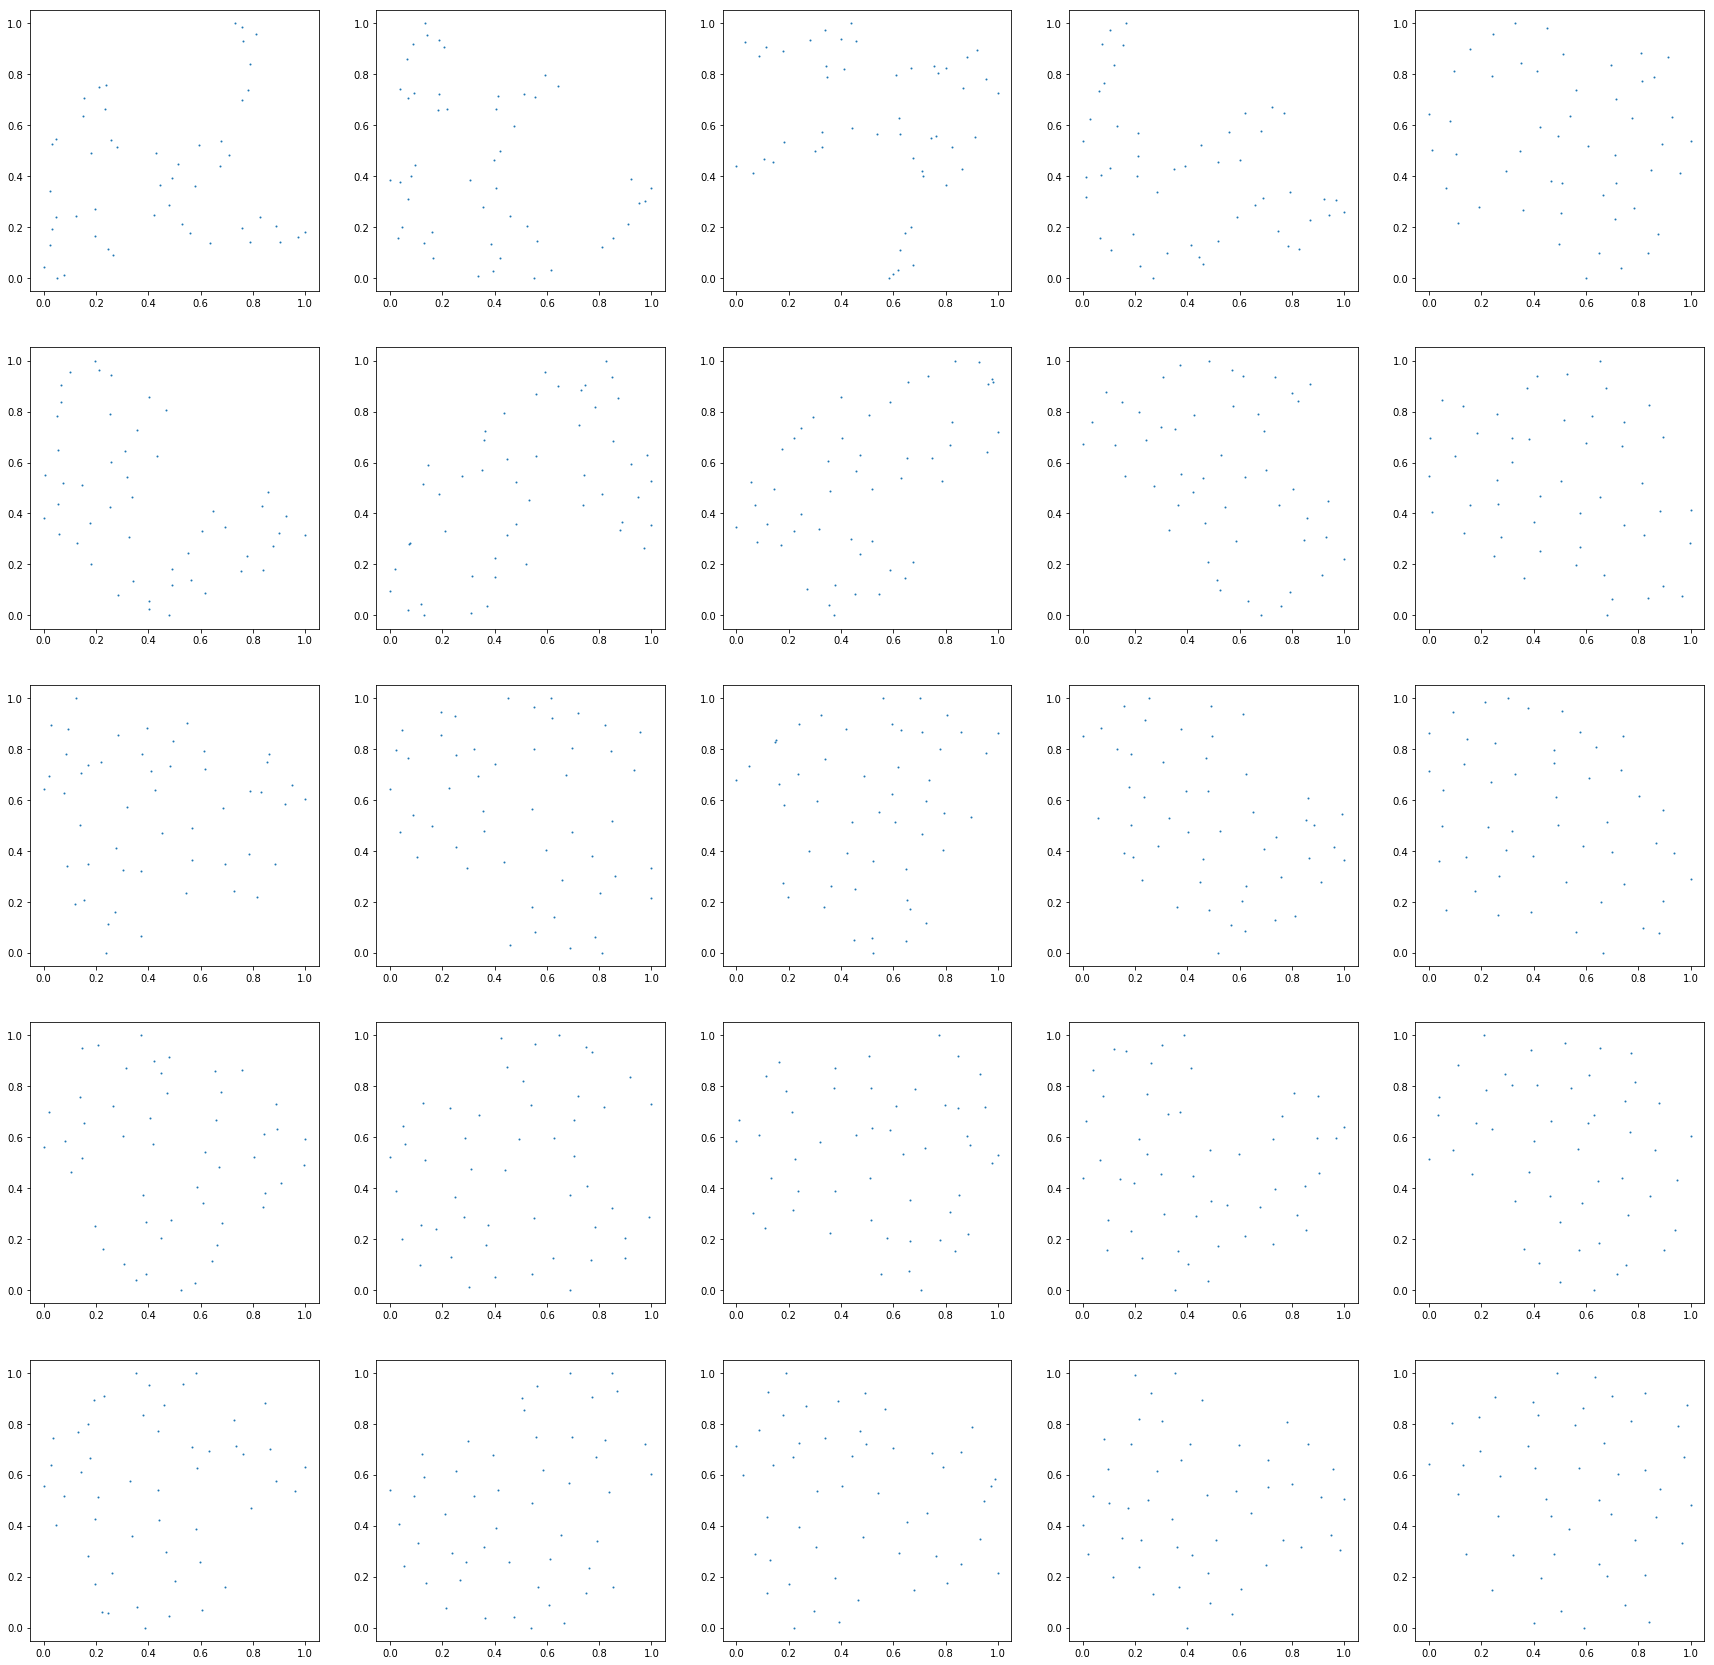

In [13]:
fig, ax = plt.subplots(nrows=len(neighbours), 
                       ncols=len(distances),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(iterations) + j
        col.scatter(umap_embeddings_mfccs[current_plot].T[0], 
                    umap_embeddings_mfccs[current_plot].T[1], 
                    s=1)
plt.show()

### And last but not least, the PCA plots!

In [14]:
def get_pca(features):
    pca = PCA(n_components=2)
    transformed = pca.fit(features).transform(features)
    scaler = MinMaxScaler()
    scaler.fit(transformed)
    return scaler.transform(transformed)

pca_mfcc = get_pca(mfcc_features)
pca_wavenet = get_pca(wavenet_features)

mfcc_key = 'pcamfcc'
wavenet_key = 'pcawavenet' 

all_json[mfcc_key] = transform_numpy_to_json(pca_mfcc)
all_json[wavenet_key] = transform_numpy_to_json(pca_wavenet)

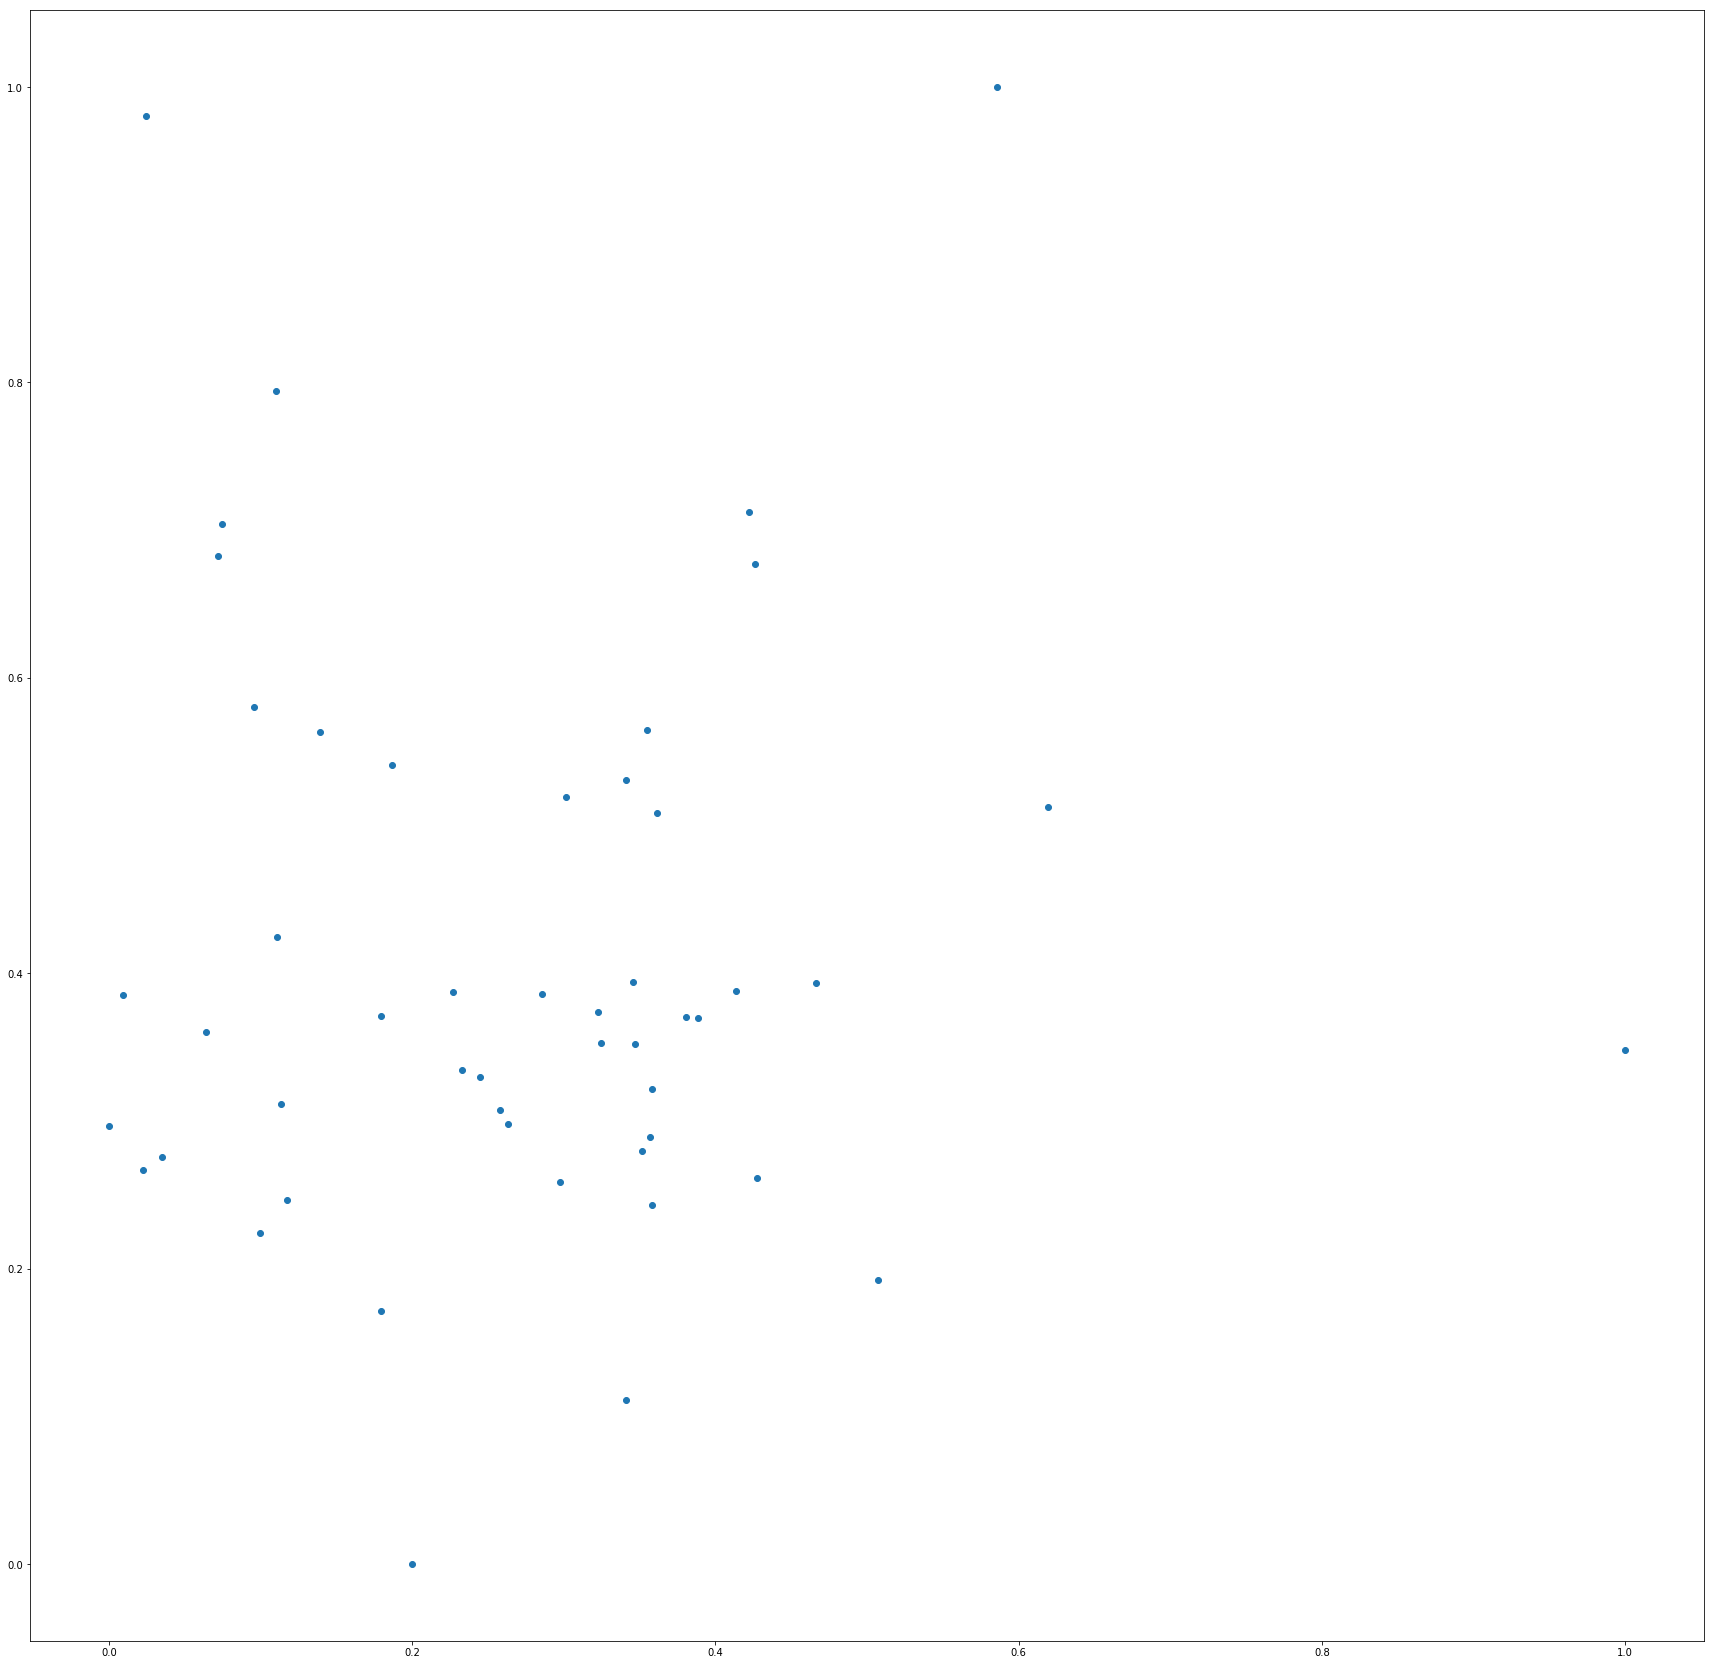

In [15]:
plt.figure(figsize=(30, 30))
_ = plt.scatter(pca_mfcc.T[0],
                pca_mfcc.T[1])
plt.show()

Its a bit weird but saving the data in this manner allows for synchrnous loading in a html file. 

In [11]:
json_name = "data.json"
json_string = "d = '" + json.dumps(all_json) + "'"
with open(json_name, 'w') as json_file:
    json_file.write(json_string)